# PAMAP2 - ResNet-Transformer


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from torchsummary import summary
from sklearn.manifold import TSNE
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        ys.append(stats.mode(labels, keepdims=True)[0][0])
        Xs.append(x)
    return np.array(Xs), np.array(ys).reshape(-1, 1)

def prepare_data_split(df, time_steps, steps, activity_mapping):
    X = df.drop(columns=['activityID', 'subject'])
    y = df['activityID'].map(activity_mapping)
    X_seq, y_seq = create_dataset(X, y, time_steps, steps)
    return X_seq, y_seq.flatten()

In [ ]:
class PAMAP2Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
class ResNetBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(ResNetBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, 1, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1, stride),
                nn.BatchNorm1d(out_channels)
                )
        else:
            self.downsample = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        """
        Args:
            d_model: 임베딩 벡터의 차원
            dropout: 드롭아웃 확률
            max_len: 처리할 수 있는 최대 시퀀스 길이
        """
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # 위치 정보를 담을 빈 텐서 생성 (max_len, d_model)
        pe = torch.zeros(max_len, d_model)

        # 각 위치 인덱스를 나타내는 텐서 생성 (max_len, 1)
        # 예: [[0], [1], [2], ...]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Positional Encoding 계산을 위한 주파수(frequency) 항 계산
        # 1 / (10000^(2i / d_model)) 수식을 log 스케일에서 계산하여 안정성을 높임
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # (d_model / 2,)

        # 짝수 인덱스에는 sin 함수 적용
        # broadcasting 적용(더 작은 쪽에 1인 차원을 추가) -> (1, d_model / 2)로 확장해서 연산
        pe[:, 0::2] = torch.sin(position * div_term)

        # 홀수 인덱스에는 cos 함수 적용
        pe[:, 1::2] = torch.cos(position * div_term)

        # pe 텐서를 모델의 버퍼(buffer)로 등록
        # 버퍼는 모델의 파라미터(가중치)와 달리 학습 중에 업데이트되지 않는 상태 값
        # 모델 저장 및 로드 시 함께 관리되며, .to(device) 호출 시 GPU로 이동
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: 입력 텐서 (shape: [batch_size, sequence_length, d_model])
            (batch_first=True인 경우를 가정)
        """
        # 입력 텐서 x에 미리 계산된 positional encoding 값을 더함
        # x의 모양: (batch, seq_len, d_model)
        # self.pe의 모양: (max_len, d_model)

        #  pe 슬라이스의 shape -> (seq_len, d_model)
        pe_slice = self.pe[:x.size(1)]

        # unsqueeze(0)를 통해 pe 슬라이스를 (1, seq_len, d_model)로 만듦 -> x와 브로드캐스팅을 통해 덧셈이 가능해짐
        x = x + pe_slice.unsqueeze(0)

        return self.dropout(x)

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward=512, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, # 입력 특징 벡터의 차원
            nhead=nhead, # 어텐션 헤드의 개수 (여러 관점에서 관계를 보게 함)
            dim_feedforward=dim_feedforward, # 내부 피드포워드 신경망의 차원
            dropout=dropout,
            batch_first=True # 입력 텐서의 첫 번째 차원을 배치로 설정 (Batch Size, Sequence Length, Features)
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

    def forward(self, x):
        return self.transformer_encoder(x)

In [ ]:
# ResNet + Transformer 모델
class ResNetTransformerHAR(nn.Module):
    def __init__(self, num_classes, input_channels, d_model=128, nhead=4, num_layers=4):
        super(ResNetTransformerHAR, self).__init__()

        # Stem
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64);
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # ResNet
        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)

        # Transformer 입력에 맞게 차원 조정
        self.feature_proj = nn.Linear(128, d_model)

        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = TransformerEncoder(d_model, nhead, num_layers)

        # classifier
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    # ResNet 블록을 여러 개 쌓는 헬퍼 함수
    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = [ResNetBlock1D(in_channels, out_channels, stride=stride)]
        for _ in range(1, blocks):
            layers.append(ResNetBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers) # unpacking layers

    def forward(self, x):
        x = self.conv1(x);
        x = self.bn1(x);
        x = self.relu(x);
        x = self.maxpool(x)
        x = self.layer1(x);
        x = self.layer2(x)

        # Transformer 입력 형식에 맞게 변환 (batch, channels, seq_len) -> (batch, seq_len, channels)
        x = x.transpose(1, 2);
        x = self.feature_proj(x)

        x = self.pos_encoder(x)
        x = self.transformer(x)

        x = x.transpose(1, 2);  # (batch, seq_len, channels) -> (batch, channels, seq_len)
        x = self.global_pool(x).squeeze(-1); # (batch, channels)
        x = self.dropout(x)

        output = self.classifier(x)
        return output

    def get_features(self, x):
        x = self.conv1(x);
        x = self.bn1(x);
        x = self.relu(x);
        x = self.maxpool(x)
        x = self.layer1(x);
        x = self.layer2(x)
        x = x.transpose(1, 2);
        x = self.feature_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.transpose(1, 2)
        x = self.global_pool(x).squeeze(-1)
        return x

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        data = data.permute(0, 2, 1)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            data = data.permute(0, 2, 1)
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [ ]:
# Start the main LOSO logic
# Load data
df = pd.read_csv('/content/drive/MyDrive/AI_data/PAMAP2/PAMAP2_integrated_data.csv')

# Handle NaN values and map activities
activity_mapping = {
    1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6,
    12: 7, 13: 8, 16: 9, 17: 10, 24: 11
}
df = df[df['activityID'].isin(activity_mapping.keys())]

df_list = []
for activity_id in df['activityID'].unique():
    activity_df = df[df['activityID'] == activity_id].copy()
    activity_df[activity_df.select_dtypes(exclude='object').columns] = (
        activity_df.select_dtypes(exclude='object').interpolate(method='linear')
    )
    activity_df = activity_df.ffill().bfill()
    df_list.append(activity_df)

df_processed = pd.concat(df_list, ignore_index=True)

torchsummary 호환성 문제
- TransformerEncoder는 MultiheadAttention 모듈을 사용
- 어텐션 모듈은 forward 연산 시 어텐션 출력 텐서와 가중치 텐서를 튜플 형태로 반환
- TransformerEncoder는 가중치 값이 필요하지 않을 때 (tensor, None)을 반환
- torchsummary는 모든 하위 모듈 출력을 추적, None 값에 대해서도 .size() 메서드를 호출 -> AttributeError가 남
- 따라서 summary 대신 print(model) 사용

In [ ]:
# Define constants
TIME_STEPS = 100
STEPS = 50
num_epochs = 100
patience = 20

# LOSO Subjects
loso_test_subjects = ['Protocol_subject101', 'Protocol_subject102', 'Protocol_subject105', 'Protocol_subject106', 'Protocol_subject108']
all_subjects = df_processed['subject'].unique().tolist()

# Lists to store results across all folds
all_preds = []
all_labels = []
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
all_X_test = []

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# LOSO Loop
for fold_idx, test_subject in enumerate(loso_test_subjects):
    print(f"--- Starting LOSO Fold {fold_idx + 1}/{len(loso_test_subjects)}: Test Subject: {test_subject} ---")

    # Set up training, validation, and test sets for the current fold
    if test_subject == 'Protocol_subject105':
        val_subject = 'Protocol_subject106'
    else:
        val_subject = 'Protocol_subject105'

    train_subjects = [s for s in all_subjects if s not in [test_subject, val_subject]]

    train_df = df_processed[df_processed['subject'].isin(train_subjects)].copy()
    val_df = df_processed[df_processed['subject'] == val_subject].copy()
    test_df = df_processed[df_processed['subject'] == test_subject].copy()

    # Scale data
    features_to_scale = df_processed.columns.drop(['subject', 'activityID'])
    scaler = MinMaxScaler()
    train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])
    val_df[features_to_scale] = scaler.transform(val_df[features_to_scale])
    test_df[features_to_scale] = scaler.transform(test_df[features_to_scale])

    # Prepare data for PyTorch
    X_train, y_train = prepare_data_split(train_df, TIME_STEPS, STEPS, activity_mapping)
    X_val, y_val = prepare_data_split(val_df, TIME_STEPS, STEPS, activity_mapping)
    X_test, y_test = prepare_data_split(test_df, TIME_STEPS, STEPS, activity_mapping)
    all_X_test.append(X_test)

    train_dataset = PAMAP2Dataset(X_train, y_train)
    val_dataset = PAMAP2Dataset(X_val, y_val)
    test_dataset = PAMAP2Dataset(X_test, y_test)

    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Re-initialize model, criterion, and optimizer for each fold
    input_features = X_train.shape[2]
    num_classes = len(np.unique(y_train))
    model = ResNetTransformerHAR(num_classes, input_features).to(device)

     # Print summary for the first fold only
    if fold_idx == 0:
        print("\n--- Model Summary (Fold 1) ---")
        print(model)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, min_lr=1e-5)

    best_val_loss = float('inf')
    patience_counter = 0

    fold_train_losses, fold_val_losses = [], []
    fold_train_accuracies, fold_val_accuracies = [], []

    # Training loop
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        fold_train_losses.append(train_loss)
        fold_val_losses.append(val_loss)
        fold_train_accuracies.append(train_acc)
        fold_val_accuracies.append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'PAMAP2_Res_Transformer_best_fold_{fold_idx}.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered for fold {fold_idx+1} after {epoch+1} epochs')
                break

    all_train_losses.append(fold_train_losses)
    all_val_losses.append(fold_val_losses)
    all_train_accuracies.append(fold_train_accuracies)
    all_val_accuracies.append(fold_val_accuracies)

    # Evaluation on the test set
    model.load_state_dict(torch.load(f'PAMAP2_Res_Transformer_best_fold_{fold_idx}.pth'))
    model.eval()
    fold_preds = []
    fold_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.permute(0, 2, 1)
            output = model(data)
            _, predicted = torch.max(output, 1)
            fold_preds.extend(predicted.cpu().numpy())
            fold_labels.extend(target.cpu().numpy())

    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

print("\nTraining completed!")

Using device: cuda
--- Starting LOSO Fold 1/5: Test Subject: Protocol_subject101 ---

--- Model Summary (Fold 1) ---
ResNetTransformerHAR(
  (conv1): Conv1d(53, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock1D(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock1D(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0

In [ ]:
# 마지막 폴드에서 저장한 모델 로드
last_fold_idx = len(loso_test_subjects) - 1
model.load_state_dict(torch.load(f'PAMAP2_Res_Transformer_best_fold_{last_fold_idx}.pth'))

# 마지막 폴드의 train_loader를 사용하여 훈련 데이터에 대한 성능을 측정
train_loss, train_acc = validate_epoch(model, train_loader, criterion, device)
print(f"Training accuracy: {train_acc:.2f}%")
print(f"Training loss: {train_loss:.4f}")

# 마지막 폴드의 test_loader를 사용하여 테스트 데이터에 대한 성능을 측정
test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)
print(f"Test accuracy: {test_acc:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 96.82%
Training loss: 0.0949
Test accuracy: 45.54%
Test loss: 2.6803


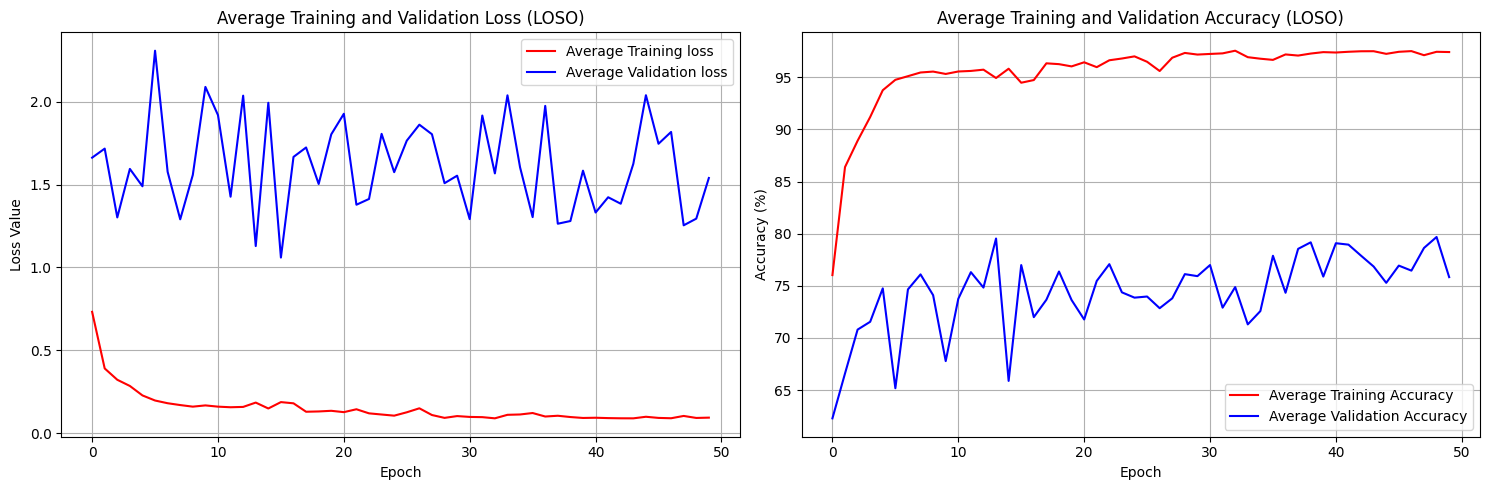

In [ ]:
# Aggregate and Visualize Final Results
max_len = max(len(l) for l in all_train_losses)
padded_train_losses = np.array([l + [l[-1]] * (max_len - len(l)) for l in all_train_losses])
padded_val_losses = np.array([l + [l[-1]] * (max_len - len(l)) for l in all_val_losses])
padded_train_accuracies = np.array([l + [l[-1]] * (max_len - len(l)) for l in all_train_accuracies])
padded_val_accuracies = np.array([l + [l[-1]] * (max_len - len(l)) for l in all_val_accuracies])

avg_train_loss = np.mean(padded_train_losses, axis=0)
avg_val_loss = np.mean(padded_val_losses, axis=0)
avg_train_acc = np.mean(padded_train_accuracies, axis=0)
avg_val_acc = np.mean(padded_val_accuracies, axis=0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(avg_train_loss, 'r', label='Average Training loss')
plt.plot(avg_val_loss, 'b', label='Average Validation loss')
plt.title('Average Training and Validation Loss (LOSO)')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(avg_train_acc, 'r', label='Average Training Accuracy')
plt.plot(avg_val_acc, 'b', label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy (LOSO)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


--- Final Classification Report (Aggregated LOSO) ---
                   precision    recall  f1-score   support

            lying     0.8222    0.7468    0.7827      2433
          sitting     0.7123    0.6373    0.6727      2374
         standing     0.5639    0.4083    0.4737      2378
          walking     0.6344    0.6346    0.6345      2882
          running     0.6459    0.5437    0.5904      1889
          cycling     0.7718    0.7644    0.7681      2385
   Nordic walking     0.4029    0.3763    0.3892      2636
 ascending stairs     0.6598    0.7285    0.6924      1451
descending stairs     0.3554    0.5353    0.4272      1274
  vacuum cleaning     0.6484    0.9079    0.7565      2269
          ironing     0.7353    0.7709    0.7527      3125
     rope jumping     0.5176    0.3778    0.4368       855

         accuracy                         0.6359     25951
        macro avg     0.6225    0.6193    0.6147     25951
     weighted avg     0.6399    0.6359    0.6327     25951

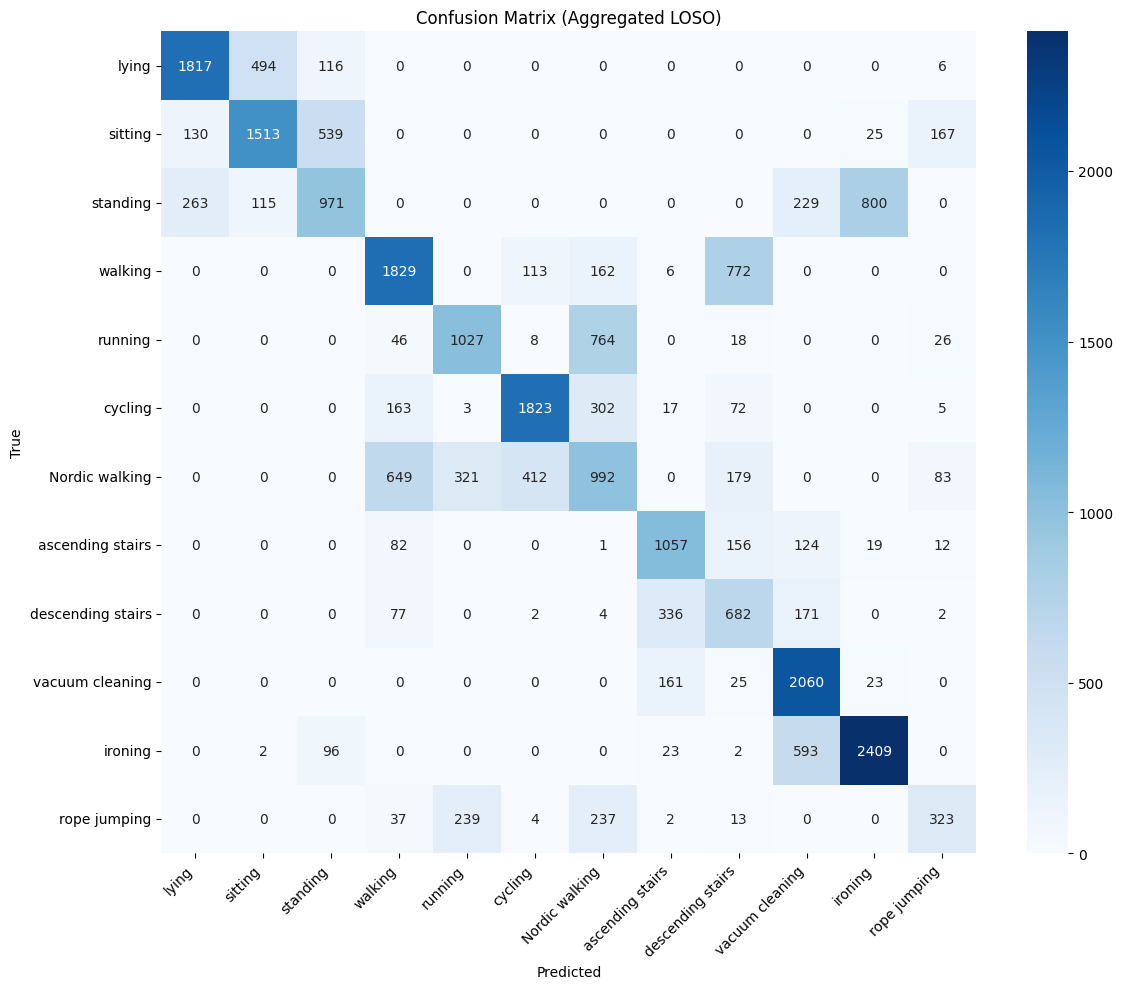

In [ ]:
# Final Classification Report and Confusion Matrix
print("\n--- Final Classification Report (Aggregated LOSO) ---")
LABELS = ['lying', 'sitting', 'standing', 'walking', 'running', 'cycling',
          'Nordic walking', 'ascending stairs', 'descending stairs',
          'vacuum cleaning', 'ironing', 'rope jumping']
target_names = [LABELS[i] for i in np.unique(all_labels)]
print(classification_report(all_labels, all_preds, digits=4, target_names=target_names))

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Aggregated LOSO)')
plt.gca().set_xticklabels(target_names, rotation=45, ha='right')
plt.gca().set_yticklabels(target_names, rotation=0)
plt.tight_layout()
plt.show()